In [1]:
%load_ext autoreload

In [1]:
import torch
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
from memflow.phasespace.rambo_generator import FlatInvertiblePhasespace
#from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from  memflow.phasespace.utils import *
torch.set_default_dtype(torch.double)

2023-03-15 17:07:06.158737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:07:07.579268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-03-15 17:07:07.579634: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-0

In [12]:
import sys
sys.path.append("/home/valsdav/code/MEM/LHAPDF-6.5.3_install/lib/python3.9/site-packages")
import lhapdf
pdf = lhapdf.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")

LHAPDF 6.5.3 loading /opt/LHAPDF/share/LHAPDF/NNPDF40_nnlo_hessian_pdfas/NNPDF40_nnlo_hessian_pdfas_0000.dat
NNPDF40_nnlo_hessian_pdfas PDF set, member #0, version 1; LHAPDF ID = 331600


In [2]:
import pdfflow
pdf = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdf.trace()

2023-01-04 11:23:49.246282: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/LHAPDF/lib:/opt/MG5_aMC_v3_4_1/lib:/.singularity.d/libs
2023-01-04 11:23:49.246310: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
[INFO] (pdfflow.pflow) Loading member 0 from NNPDF40_nnlo_hessian_pdfas
[INFO] (pdfflow.pflow) Building tf.Graph, this can take a while...


In [3]:
TOP_MASS = 172.76
HIGGS_MASS = 125.25
E_CM = 13000
final_masses = torch.tensor([HIGGS_MASS, TOP_MASS, TOP_MASS], requires_grad=False)

# Parton fractions x1 x2 correct generation

If we want to sample uniformly x1 and x2 of the pdf we have to incorporate the constraint from the minimum of the final state particle masses.

In the rambo generato one can use the tau=True option but that produces a non flat distribution.

In [4]:
Mfinal = torch.sum(final_masses)
min_fract = Mfinal/E_CM
min_fract

tensor(0.0362)

In [5]:
rnd = torch.rand(100000, 1)
rnd2 = torch.rand(100000, 1)

In [6]:
x1, w = uniform_distr(rnd, min_fract,1)

In [7]:
x1

tensor([[0.6372],
        [0.7810],
        [0.4523],
        ...,
        [0.5173],
        [0.7800],
        [0.1273]])

In [8]:
x2, w = uniform_distr_t(rnd2, min_fract/x1, torch.ones_like(rnd2))

(array([10021.,  9996., 10072., 10016., 10167.,  9967.,  9907.,  9798.,
        10101.,  9955.]),
 array([0.03625005, 0.13262311, 0.22899617, 0.32536924, 0.4217423 ,
        0.51811536, 0.61448842, 0.71086148, 0.80723454, 0.9036076 ,
        0.99998066]),
 <BarContainer object of 10 artists>)

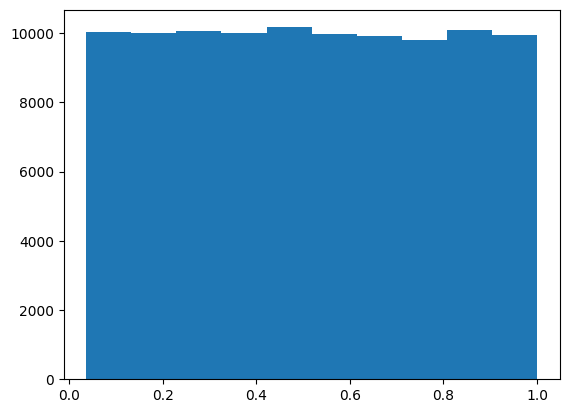

In [10]:
plt.hist(x1.flatten())

(array([ 5531.,  8599.,  9468.,  9965., 10476., 10529., 10990., 11073.,
        11454., 11915.]),
 array([0.03693464, 0.13324101, 0.22954738, 0.32585374, 0.42216011,
        0.51846647, 0.61477284, 0.7110792 , 0.80738557, 0.90369193,
        0.9999983 ]),
 <BarContainer object of 10 artists>)

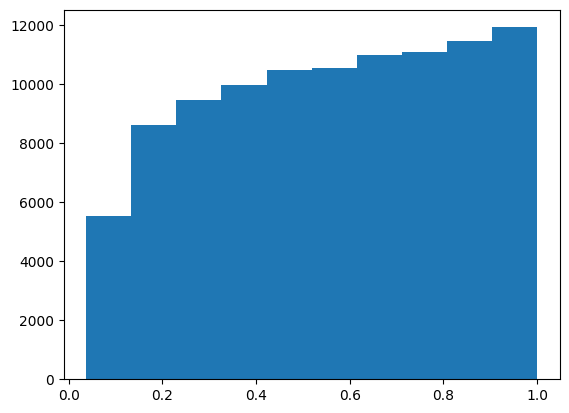

In [10]:
plt.hist(x2.flatten())

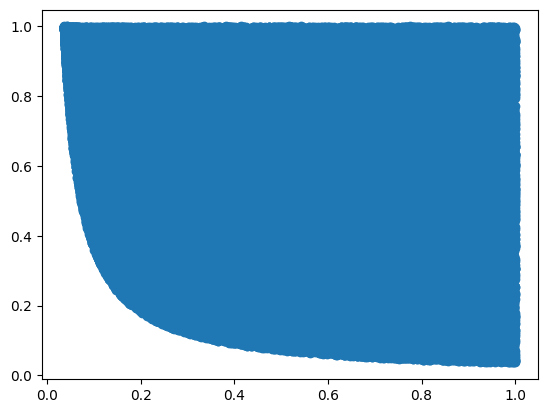

In [11]:
plt.scatter(x1.flatten(), x2.flatten())

Text(0, 0.5, 'x2')

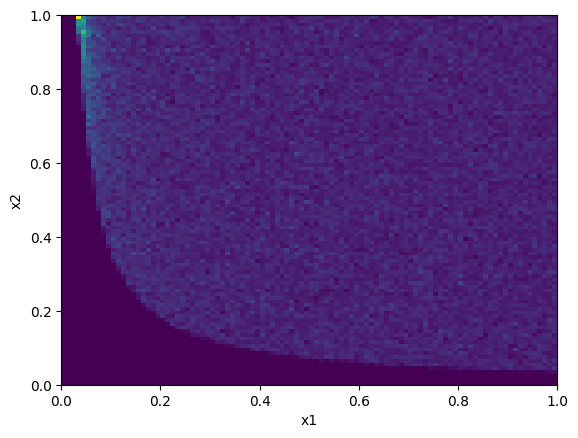

In [12]:
plt.hist2d(x1.flatten().numpy(), x2.flatten().numpy(),
          bins=(100,100), range=((0.,1.),(0.,1.))
          )
plt.xlabel("x1")
plt.ylabel("x2")

# Partons generation

In [9]:
gen = FlatInvertiblePhasespace([0.,0.],torch.tensor([HIGGS_MASS, TOP_MASS, TOP_MASS]), 
                                   pdf=None, pdf_active=True, tau=False)

# The tau=True does not use x1 and x2 and parton fraction, but computes the E_CM in a different way
gen_tau = FlatInvertiblePhasespace([0.,0.],torch.tensor([HIGGS_MASS, TOP_MASS, TOP_MASS]), 
                                   pdf=None, pdf_active=True, tau=True)

In [10]:
# Total Phase space volume with 3 final state particles
FlatInvertiblePhasespace.get_flatWeights(E_CM, 3)

21291.052028166854

In [11]:
rnd = torch.cat((torch.rand(100000, 5), x2, x1), axis=1)
rnd_tau = torch.rand(100000, 7)

In [12]:
p, w, x1, x2 = gen.generateKinematics_batch(E_CM, rnd, pdgs=[21,21])
p_tau, w_tau, x1_tau, x2_tau = gen.generateKinematics_batch(E_CM, rnd_tau, pdgs=[21,21])

In [59]:
%%timeit
p, w, x1, x2 = gen.generateKinematics_batch(E_CM, rnd, pdgs=[21,21])

1.27 s ± 21.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Text(0.5, 0, 'log10(weight)')

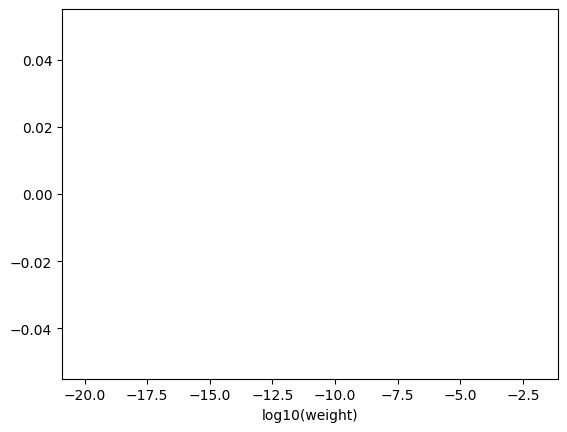

In [13]:
plt.hist(torch.log10(w), bins=100, range=(-20, -2))
plt.xlabel("log10(weight)")

Text(0.5, 0, 'Pz')

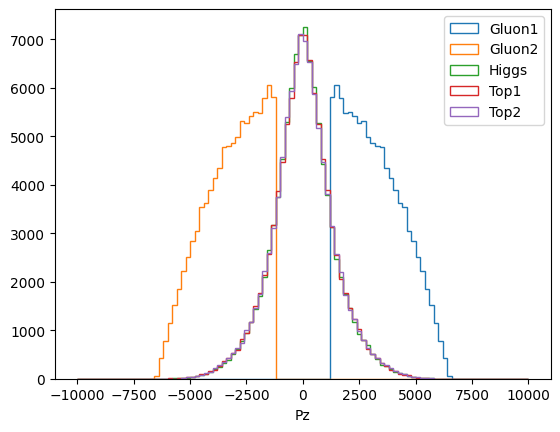

In [14]:
plt.hist(p[:,0,3], bins=100, range=(-1e4,1e4), histtype="step", label="Gluon1")
plt.hist(p[:,1,3], bins=100, range=(-1e4,1e4), histtype="step", label="Gluon2")
plt.hist(p[:,2,3], bins=100, range=(-1e4,1e4), histtype="step", label="Higgs")
plt.hist(p[:,3,3], bins=100, range=(-1e4,1e4), histtype="step", label="Top1")
plt.hist(p[:,4,3], bins=100, range=(-1e4,1e4), histtype="step", label="Top2")
plt.legend()
plt.xlabel("Pz")

Text(0.5, 0, 'Pz weighted')

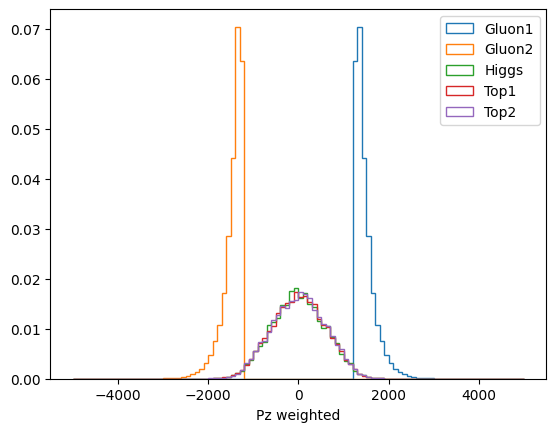

In [25]:
plt.hist(p[:,0,3], weights=w,  bins=100, range=(-5e3, 5e3), histtype="step", label="Gluon1")
plt.hist(p[:,1,3],  weights=w,bins=100, range=(-5e3, 5e3), histtype="step", label="Gluon2")
plt.hist(p[:,2,3], weights=w, bins=100, range=(-5e3, 5e3), histtype="step", label="Higgs")
plt.hist(p[:,3,3],  weights=w,bins=100, range=(-5e3, 5e3), histtype="step", label="Top1")
plt.hist(p[:,4,3],  weights=w,bins=100, range=(-5e3, 5e3), histtype="step", label="Top2")
plt.legend()
plt.xlabel("Pz weighted")

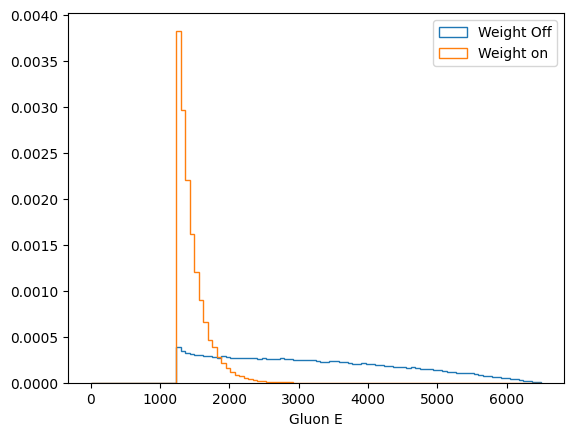

In [29]:
plt.hist(p[:,0,0], bins=100, range=(0,6500), density=True, histtype="step", label="Weight Off")
plt.hist(p[:,0,0], weights=w, bins=100,range=(0,6500),  density=True, histtype="step", label="Weight on")
plt.xlabel("Gluon E")
plt.legend()

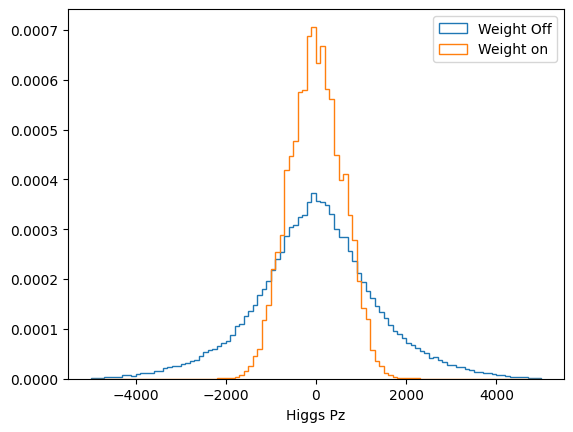

In [30]:
plt.hist(p[:,2,3], bins=100, range=(-5000,5000), density=True, histtype="step", label="Weight Off")
plt.hist(p[:,2,3], weights=w, bins=100,range=(-5000,5000),  density=True, histtype="step", label="Weight on")
plt.xlabel("Higgs Pz")
plt.legend()

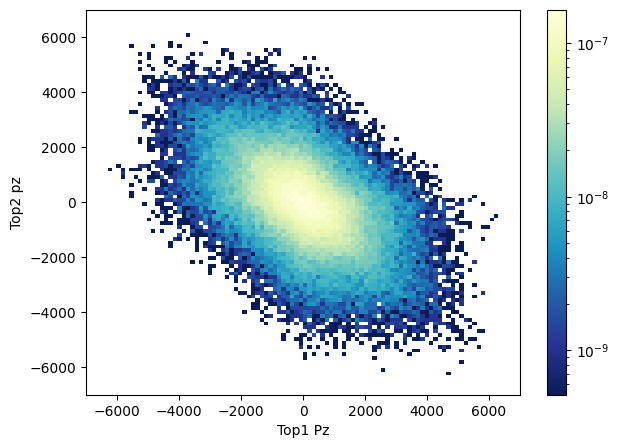

In [31]:
plt.figure(figsize=(7,5))
plt.hist2d(p[:,3,3].numpy(),p[:,4,3].numpy(),
            range=((-7000,7000),(-7000,7000)), 
           bins=100, density=True, cmap="YlGnBu_r", norm=colors.LogNorm())
plt.xlabel("Top1 Pz")
plt.ylabel("Top2 pz")
plt.colorbar()

### 2d weighted phase space 
By using the weights the phase space is indeed flat in the parton space

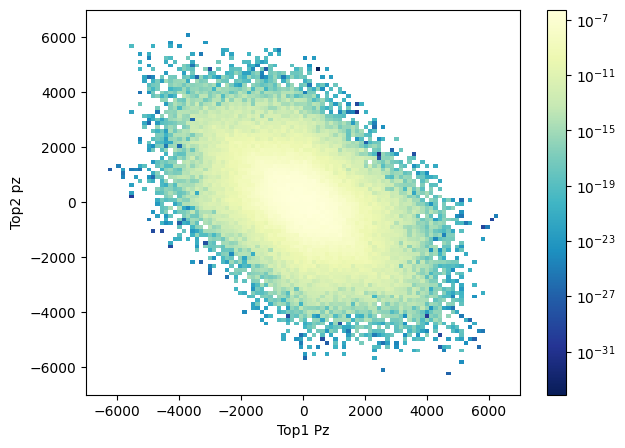

In [32]:
plt.figure(figsize=(7,5))
plt.hist2d(p[:,3,3].numpy(),p[:,4,3].numpy(),
           weights=w, range=((-7000,7000),(-7000,7000)), 
           bins=100, density=True, cmap="YlGnBu_r", norm=colors.LogNorm())
plt.xlabel("Top1 Pz")
plt.ylabel("Top2 pz")
plt.colorbar()

## Boosting to lab frame

In [33]:
p_lab = p.clone()
boost_to_lab_frame(p_lab, x1, x2)

tensor([[[ 2560.5370,     0.0000,     0.0000,  2560.5370],
         [ 3971.9094,     0.0000,     0.0000, -3971.9094],
         [ 2700.5075,  1416.3033, -1579.2534,  1666.4625],
         [ 2796.4414, -1311.8267,  1272.0864, -2109.7738],
         [ 1035.4976,  -104.4766,   307.1670,  -968.0611]],

        [[ 4784.0646,     0.0000,     0.0000,  4784.0646],
         [ 5181.3682,     0.0000,     0.0000, -5181.3682],
         [ 4057.5351, -3878.5548,    54.2510,  1183.9647],
         [ 3517.6137,  2415.0986,  1815.8293, -1792.7137],
         [ 2390.2844,  1463.4562, -1870.0803,   211.4453]],

        [[ 1275.2805,     0.0000,     0.0000,  1275.2805],
         [ 4811.1999,     0.0000,     0.0000, -4811.1999],
         [ 1884.0360,  -365.3002, -1708.6788,  -693.4527],
         [ 2583.3745,  1322.0507,  1574.4303, -1554.7761],
         [ 1619.0698,  -956.7505,   134.2485, -1287.6905]],

        ...,

        [[ 4659.5161,     0.0000,     0.0000,  4659.5161],
         [ 5842.1064,     0.0000,   

Text(0, 0.5, 'Gluon2 pz (CM)')

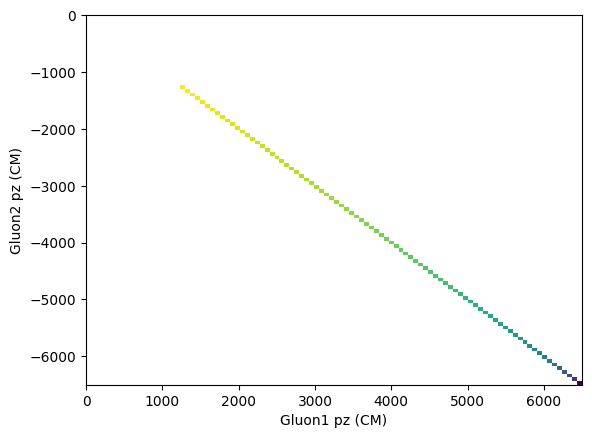

In [43]:
plt.hist2d(p[:,0,3].numpy(),p[:,1,3].numpy(), weights=w,
          bins=(100,100), range=((0., 6500.),(-6500,0.)),
          norm=colors.LogNorm())
plt.xlabel("Gluon1 pz (CM)")
plt.ylabel("Gluon2 pz (CM)")

Text(0, 0.5, 'Gluon2 pz (LAB)')

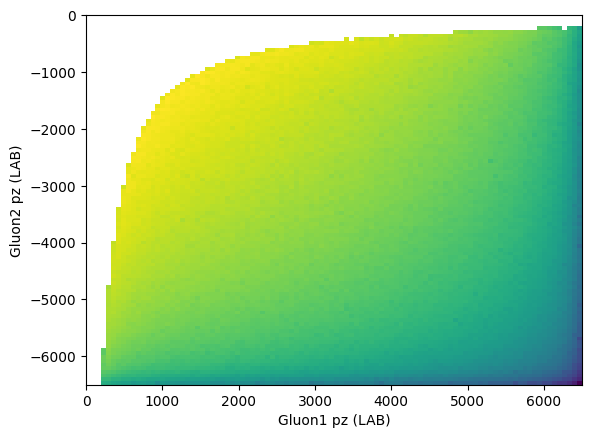

In [44]:
plt.hist2d(p_lab[:,0,3].numpy(),p_lab[:,1,3].numpy(), weights=w,
          bins=(100,100), range=((0., 6500.),(-6500,0.)),
          norm=colors.LogNorm())
plt.xlabel("Gluon1 pz (LAB)")
plt.ylabel("Gluon2 pz (LAB)")

Text(0.5, 0, 'Pz')

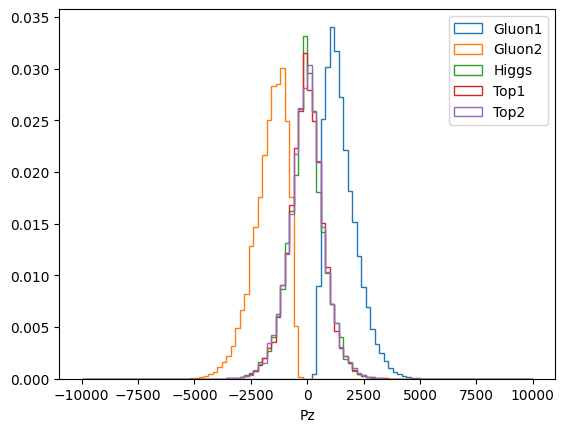

In [34]:
,
plt.hist(p_lab[:,0,3], weights=w,  bins=100, range=(-1e4,1e4), histtype="step", label="Gluon1")
plt.hist(p_lab[:,1,3], weights=w,bins=100, range=(-1e4,1e4), histtype="step", label="Gluon2")
plt.hist(p_lab[:,2,3], weights=w, bins=100, range=(-1e4,1e4), histtype="step", label="Higgs")
plt.hist(p_lab[:,3,3], weights=w,bins=100, range=(-1e4,1e4), histtype="step", label="Top1")
plt.hist(p_lab[:,4,3], weights=w,bins=100, range=(-1e4,1e4), histtype="step", label="Top2")
plt.legend()
plt.xlabel("Pz")

Text(0, 0.5, 'Higgs pz (Lab)')

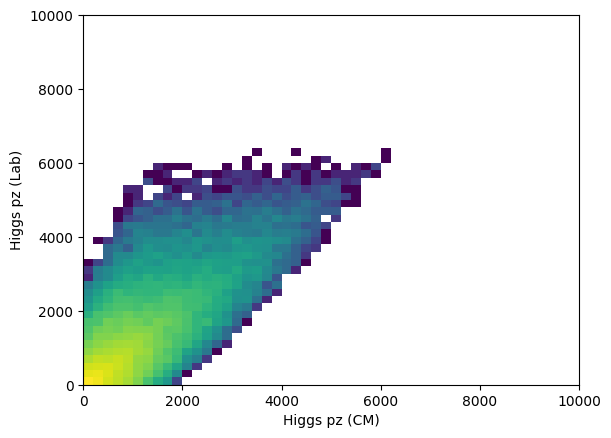

In [45]:
plt.hist2d(p[:, 3, 3].numpy(), 
           p_lab[:, 3, 3].numpy(),
          bins=(50, 50), 
           range=((0., 10000.),(0., 10000.)),
          norm=colors.LogNorm())
plt.xlabel("Higgs pz (CM)")
plt.ylabel("Higgs pz (Lab)")

Text(0.5, 0, 'En')

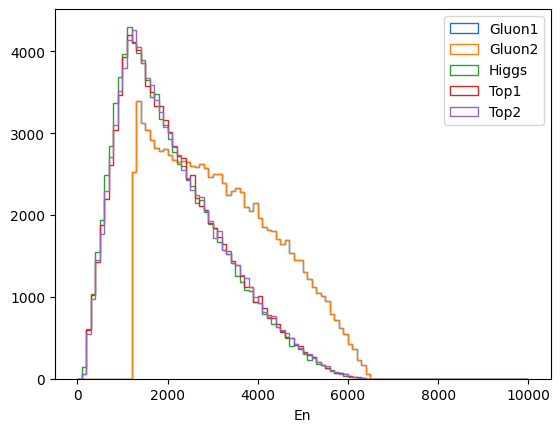

In [46]:
plt.hist(p[:,0,0], bins=100, range=(0,1e4), histtype="step", label="Gluon1")
plt.hist(p[:,1,0], bins=100, range=(0,1e4), histtype="step", label="Gluon2")
plt.hist(p[:,2,0], bins=100, range=(0,1e4), histtype="step", label="Higgs")
plt.hist(p[:,3,0], bins=100, range=(0,1e4), histtype="step", label="Top1")
plt.hist(p[:,4,0], bins=100, range=(0,1e4), histtype="step", label="Top2")
plt.legend()
plt.xlabel("En")

# Inverse transformation

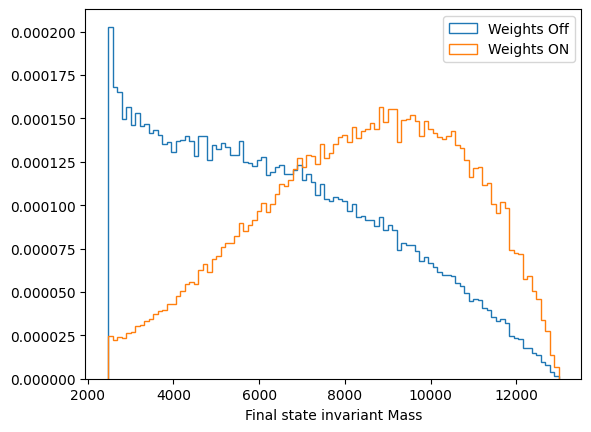

In [15]:
Mfinal =  torch.sqrt(square_t(torch.sum(p[:,2:], axis=1)))
plt.hist(Mfinal, bins=100, density=True, histtype="step", label="Weights Off")
plt.hist(Mfinal, weights=w, bins=100, density=True, histtype="step", label="Weights ON")
plt.xlabel("Final state invariant Mass")
plt.legend()

In [16]:
n = 3
P = p[:,2:].clone() # copy
M = torch.tensor([0.]*n,requires_grad=False, dtype=torch.double, device=P.device)
M = torch.unsqueeze(M, 0).repeat(P.shape[0],1)
Q = torch.zeros_like(P)
Q[:,-1] = P[:,-1]  # Qn = pn
#M[:, -1] = torch.sqrt(square_t(P[:, -1], axis=1)))
# intermediate mass
for i in range(n, 0, -1):
    j = i-1
    M[:, j] = torch.sqrt(square_t(torch.sum(P[:, j:n], axis=1)))
    # Rimuovere la massa delle particelle finali
    M[:, j] -= torch.sum(final_masses[j:])

r = torch.zeros(P.shape[0], 5)

In [23]:
Q

tensor([[[ 7.5753e+03,  0.0000e+00, -1.4211e-14,  0.0000e+00],
         [ 5.1978e+03, -2.3099e+03, -2.6474e+01, -5.4824e+02],
         [ 1.7322e+03,  3.3956e+02,  4.7109e+02,  1.6228e+03]],

        [[ 1.0808e+04, -9.9476e-14,  0.0000e+00,  0.0000e+00],
         [ 7.0756e+03, -1.0908e+02,  3.5100e+03, -1.2570e+03],
         [ 2.2506e+03,  1.9575e+03, -8.1515e+02, -7.3414e+02]],

        [[ 6.6391e+03,  0.0000e+00,  1.1369e-13, -5.6843e-14],
         [ 5.3482e+03, -1.1142e+03, -5.3950e+02, -3.4369e+02],
         [ 2.4397e+03,  3.8063e+02, -1.2858e+03,  2.0308e+03]],

        ...,

        [[ 4.3753e+03, -7.1054e-15, -1.1369e-13,  0.0000e+00],
         [ 2.7366e+03, -6.0812e+01, -7.8284e+02,  1.4329e+03],
         [ 1.6140e+03, -1.8540e+02, -1.4838e+03,  5.8231e+02]],

        [[ 3.8321e+03,  0.0000e+00,  1.4211e-14,  0.0000e+00],
         [ 2.1038e+03, -7.1370e+02, -6.9520e+01, -1.5675e+03],
         [ 1.0278e+03, -7.2990e+01, -5.3301e+02, -8.5858e+02]],

        [[ 2.7179e+03,  0.0000e

In [17]:
for i in range(n, 1, -1):
    j = i-1 #index for 0-based tensors
    # in the direct algo the u are squared. 
    u = (M[:, j]/M[:, j-1])**2
    
    r[:, j-1] = (n+1-i)*(torch.pow(u,(n-i))) - (n-i)*(torch.pow(u,(n+1-i)))
    
    Q[:, j-1] = Q[:, j] + P[:, j-1]
    
    boost_t(P[:, j-1], -boostVector_t(Q[:, j-1]))
   
    r[:, n-5+2*i-1] = ((P[:, j-1, 3]/ torch.sqrt(rho2_t(P[:, j-1]))) + 1)/2
    phi = torch.atan(P[:, j-1, 2]/P[:, j-1, 1])
    # Fixing phi depending on X and y sign
    # 4th quandrant  (px > 0, py < 0)
    deltaphi = torch.where((P[:, j-1, 2]<0)&(P[:, j-1, 1]>0), 2*torch.pi, 0.)
    # 2th and 3th quadratant  (px < 0, py whatever)
    deltaphi += torch.where((P[:, j-1, 1]<0), torch.pi, 0.)
    phi += deltaphi
    r[:, n-4+2*i-1] = phi/(2*torch.pi)
    print(j-1, n-5+2*i-1, n-4+2*i-1)
    print(r[0:5])
    

1 3 4
tensor([[0.0000, 1.0000, 0.0000, 0.0991, 0.5569],
        [0.0000, 1.0000, 0.0000, 0.5382, 0.3666],
        [0.0000, 1.0000, 0.0000, 0.0763, 0.3656],
        [0.0000, 1.0000, 0.0000, 0.6015, 0.2114],
        [0.0000, 1.0000, 0.0000, 0.4321, 0.3361]])
0 1 2
tensor([[0.5938, 0.6155, 0.0018, 0.0991, 0.5569],
        [0.5108, 0.6685, 0.7549, 0.5382, 0.3666],
        [0.8535, 0.6338, 0.0718, 0.0763, 0.3656],
        [0.1282, 0.9387, 0.3010, 0.6015, 0.2114],
        [0.8511, 0.5739, 0.1857, 0.4321, 0.3361]])


In [18]:
rnd[0:5, 0:5]

tensor([[0.5938, 0.6155, 0.0018, 0.0991, 0.5569],
        [0.5108, 0.6685, 0.7549, 0.5382, 0.3666],
        [0.8535, 0.6338, 0.0718, 0.0763, 0.3656],
        [0.1282, 0.9387, 0.3010, 0.6015, 0.2114],
        [0.8511, 0.5739, 0.1857, 0.4321, 0.3361]])

In [19]:
rnd[0:15, 0:5] - r[0:15]

tensor([[ 2.2204e-16,  0.0000e+00,  1.1514e-16,  0.0000e+00,  0.0000e+00],
        [-1.1102e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.2204e-16,  0.0000e+00, -2.7756e-17,  5.5511e-17,  5.5511e-17],
        [ 8.3267e-17,  0.0000e+00,  5.5511e-17,  0.0000e+00, -5.5511e-17],
        [-2.2204e-16,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.1102e-16],
        [ 1.3878e-16,  0.0000e+00,  0.0000e+00, -2.2204e-16, -2.2204e-16],
        [ 1.1102e-16,  0.0000e+00,  2.7756e-17,  1.1102e-16,  0.0000e+00],
        [ 2.7756e-17,  0.0000e+00,  1.1102e-16,  1.1102e-16,  0.0000e+00],
        [-1.1102e-16,  0.0000e+00,  6.9389e-18, -5.5511e-17,  0.0000e+00],
        [ 1.1102e-16,  0.0000e+00,  0.0000e+00,  5.5511e-17,  1.3878e-17],
        [-3.6082e-16,  0.0000e+00,  1.1102e-16,  4.4409e-16, -2.2204e-16],
        [ 0.0000e+00,  0.0000e+00, -1.1102e-16,  0.0000e+00,  5.5511e-17],
        [ 5.5511e-17,  0.0000e+00,  2.7756e-17,  5.5511e-17,  0.0000e+00],
        [-1.3878e-16,  0.

(array([50115., 50254., 49847., 49909., 50091., 50045., 50024., 49995.,
        49597., 50123.]),
 array([2.20696142e-06, 1.00001771e-01, 2.00001335e-01, 3.00000899e-01,
        4.00000463e-01, 5.00000028e-01, 5.99999592e-01, 6.99999156e-01,
        7.99998720e-01, 8.99998284e-01, 9.99997848e-01]),
 <BarContainer object of 10 artists>)

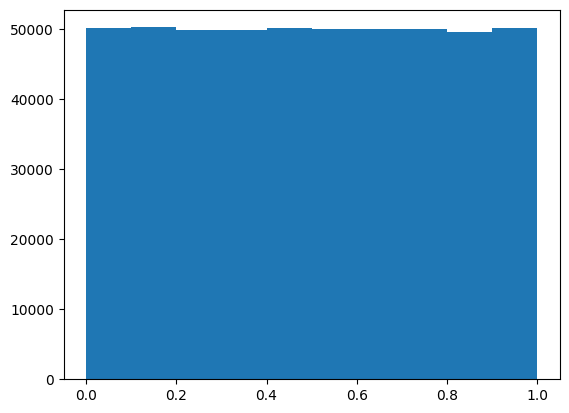

In [20]:
plt.hist(r.flatten())

## Testing inversion precision

Text(0.5, 0, '$\\log_{10}(|1- r_f/r_i|)$')

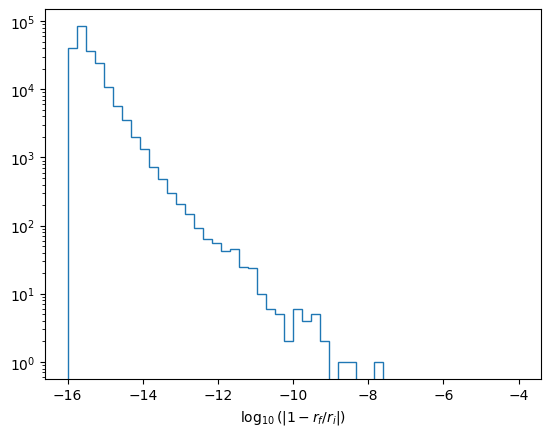

In [21]:
plt.hist(torch.log10(torch.abs(1- r/rnd[:,:-2])).flatten(), 
        range=(-16,-4), bins=50, histtype="step")
plt.yscale("log")
plt.xlabel("$\log_{10}(|1- r_f/r_i|)$")

## Testing from p -> $\rho$ -> to p
Starting from parton, going to the hypercube and then back to partons. Check the numerical difference

In [76]:
new_r = torch.cat((r, x2.unsqueeze(1), x1.unsqueeze(1)), axis=-1)

In [77]:
p2, w2, x1_2, x2_2 = gen.generateKinematics_batch(E_CM, new_r, pdgs=[21,21])

Text(0.5, 0, '$\\log_{10}(|1- p_f/p_i|)$')

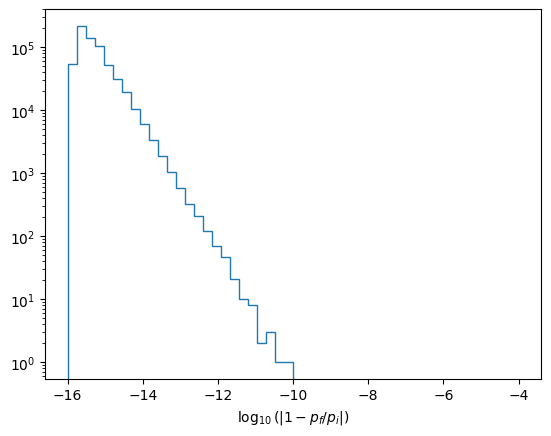

In [81]:
plt.hist(torch.log10(torch.abs(1- p/p2)).flatten(), 
        range=(-16,-4), bins=50, histtype="step")
plt.yscale("log")
plt.xlabel("$\log_{10}(|1- p_f/p_i|)$")

# Test pdf interpolation speed

In [23]:
import lhapdf
pdf_lha = lhapdf.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
x1 = torch.rand(100000)

LHAPDF 6.5.3 loading /opt/LHAPDF/share/LHAPDF/NNPDF40_nnlo_hessian_pdfas/NNPDF40_nnlo_hessian_pdfas_0000.dat
NNPDF40_nnlo_hessian_pdfas PDF set, member #0, version 1; LHAPDF ID = 331600


In [24]:
%%timeit
a = pdf_lha.xfxQ2(21, x1, x1*91.88**2) 

457 ms ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
a_lhapdf = pdf_lha.xfxQ2(21, x1, x1*91.88**2) 

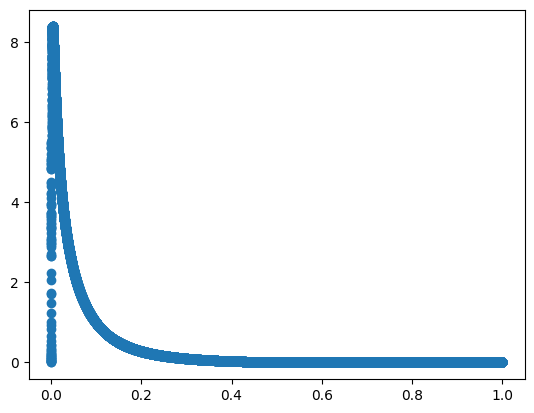

In [12]:
plt.scatter(x1, a_lhapdf)

In [26]:
import pdfflow
pdffl = pdfflow.mkPDF("NNPDF40_nnlo_hessian_pdfas/0")
pdffl.trace()

[INFO] (pdfflow.pflow) Loading member 0 from NNPDF40_nnlo_hessian_pdfas
[INFO] (pdfflow.pflow) Building tf.Graph, this can take a while...


In [27]:
x1 = tf.convert_to_tensor(x1.numpy())

In [28]:
%%timeit
a = pdffl.xfxQ2([21], x1, x1*91.88**2) 

53.7 ms ± 3.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
a_pdfflow = pdffl.xfxQ2([21], x1, x1*91.88**2) 

In [30]:
a_pdfflow

<tf.Tensor: shape=(100000,), dtype=float64, numpy=
array([7.32710584e-05, 1.12202935e+00, 4.85676157e-01, ...,
       7.47781275e-10, 1.75728487e+00, 1.14653159e-05])>

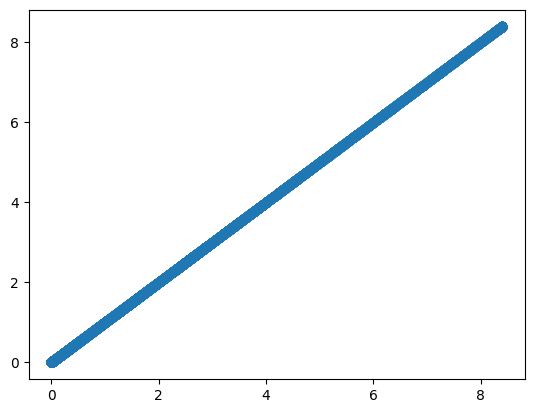

In [31]:
plt.scatter(a_lhapdf, a_pdfflow)

In [83]:
rnd.shape

torch.Size([100000, 7])

In [85]:
%%timeit
tf.convert_to_tensor(rnd)

35.3 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


# Tests

## Check if in CM

In [110]:
ref_lab = p_lab[:,0,:] + p_lab[:,1,:]

In [111]:
pp = p_lab.clone()

In [112]:
(rho2_t(ref_lab)==0).any()

tensor(False)

In [113]:
if not ((rho2_t(ref_lab)==0).any()):
    lab_boost = -boostVector_t(ref_lab)
    boost_tt(pp, lab_boost.unsqueeze(1))

In [114]:
not ((rho2_t(ref_lab)==0).any())

True

In [115]:
pp

tensor([[[ 3189.0784,     0.0000,     0.0000,  3189.0784],
         [ 3189.0784,     0.0000,     0.0000, -3189.0784],
         [ 3134.5921,  1416.3033, -1579.2534,  2304.3489],
         [ 2397.2329, -1311.8267,  1272.0864, -1542.0073],
         [  846.3319,  -104.4766,   307.1670,  -762.3416]],

        [[ 4978.7549,     0.0000,     0.0000,  4978.7549],
         [ 4978.7549,     0.0000,     0.0000, -4978.7549],
         [ 4108.0037, -3878.5548,    54.2510,  1346.8021],
         [ 3448.8835,  2415.0986,  1815.8293, -1653.7877],
         [ 2400.6229,  1463.4562, -1870.0803,   306.9856]],

        [[ 2477.0203,     0.0000,     0.0000,  2477.0203],
         [ 2477.0203,     0.0000,     0.0000, -2477.0203],
         [ 1819.7581,  -365.3002, -1708.6788,   492.7520],
         [ 2064.1929,  1322.0507,  1574.4303,   -66.3116],
         [ 1070.0895,  -956.7505,   134.2485,  -426.4403]],

        ...,

        [[ 5217.4121,     0.0000,     0.0000,  5217.4121],
         [ 5217.4121,     0.0000,   

In [106]:
pp

tensor([[[ 2.0559e+03,  0.0000e+00,  0.0000e+00,  2.0559e+03],
         [ 4.9469e+03,  0.0000e+00,  0.0000e+00, -4.9469e+03],
         [ 2.3971e+03,  1.4163e+03, -1.5793e+03,  1.1092e+03],
         [ 3.3309e+03, -1.3118e+03,  1.2721e+03, -2.7796e+03],
         [ 1.2748e+03, -1.0448e+02,  3.0717e+02, -1.2206e+03]],

        [[ 4.5970e+03,  0.0000e+00,  0.0000e+00,  4.5970e+03],
         [ 5.3922e+03,  0.0000e+00,  0.0000e+00, -5.3922e+03],
         [ 4.0135e+03, -3.8786e+03,  5.4251e+01,  1.0230e+03],
         [ 3.5919e+03,  2.4151e+03,  1.8158e+03, -1.9345e+03],
         [ 2.3837e+03,  1.4635e+03, -1.8701e+03,  1.1624e+02]],

        [[ 6.5657e+02,  0.0000e+00,  0.0000e+00,  6.5657e+02],
         [ 9.3450e+03,  0.0000e+00,  0.0000e+00, -9.3450e+03],
         [ 2.8097e+03, -3.6530e+02, -1.7087e+03, -2.1967e+03],
         [ 4.2836e+03,  1.3221e+03,  1.5744e+03, -3.7541e+03],
         [ 2.9083e+03, -9.5675e+02,  1.3425e+02, -2.7376e+03]],

        ...,

        [[ 4.1613e+03,  0.0000e+00,

In [102]:
boost_tt(pp, lab_boost.unsqueeze(1))

tensor([[[ 1.6507e+03,  0.0000e+00,  0.0000e+00,  1.6507e+03],
         [ 6.1612e+03,  0.0000e+00,  0.0000e+00, -6.1612e+03],
         [ 2.2096e+03,  1.4163e+03, -1.5793e+03,  6.0560e+02],
         [ 4.0266e+03, -1.3118e+03,  1.2721e+03, -3.5839e+03],
         [ 1.5757e+03, -1.0448e+02,  3.0717e+02, -1.5322e+03]],

        [[ 4.4172e+03,  0.0000e+00,  0.0000e+00,  4.4172e+03],
         [ 5.6117e+03,  0.0000e+00,  0.0000e+00, -5.6117e+03],
         [ 3.9759e+03, -3.8786e+03,  5.4251e+01,  8.6369e+02],
         [ 3.6720e+03,  2.4151e+03,  1.8158e+03, -2.0793e+03],
         [ 2.3810e+03,  1.4635e+03, -1.8701e+03,  2.1222e+01]],

        [[ 3.3803e+02,  0.0000e+00,  0.0000e+00,  3.3803e+02],
         [ 1.8151e+04,  0.0000e+00,  0.0000e+00, -1.8151e+04],
         [ 5.0198e+03, -3.6530e+02, -1.7087e+03, -4.7042e+03],
         [ 7.9422e+03,  1.3221e+03,  1.5744e+03, -7.6696e+03],
         [ 5.5270e+03, -9.5675e+02,  1.3425e+02, -5.4392e+03]],

        ...,

        [[ 3.7163e+03,  0.0000e+00,

In [100]:
lab_boost

tensor([[ 0.0000,  0.0000, -0.2161],
        [ 0.0000,  0.0000, -0.0399],
        [ 0.0000,  0.0000, -0.5809],
        ...,
        [ 0.0000,  0.0000, -0.1126],
        [ 0.0000,  0.0000,  0.2506],
        [ 0.0000,  0.0000,  0.2847]])